In [3]:
# Solicitud de datos a la API REST
from matplotlib.axis import Axis
from api_somo import APIClient, fetch_qf 
import logging
import numpy as np
import pandas as pd

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2009-01-01",
    "end_date":"2023-12-31"
    }

try:
    # 1. Fetch and process the data
    red_mpomm_serie,  red_mpomm_metadata = APIClient.fetch_and_process_data(api_url, params)
    #red_mpomm_serie.index = red_mpomm_serie.index.strftime('%Y-%m-%d %H:%M')


    if red_mpomm_serie.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {red_mpomm_serie.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")



display(round(red_mpomm_serie.describe(),3))
red_mpomm_serie.loc[red_mpomm_serie['qf'] != 1, 'value'] = np.nan
red_mpomm_serie.index = pd.to_datetime(red_mpomm_serie.index)
red_mpomm_serie=red_mpomm_serie['value']
#red_mpomm_serie = red_mpomm_serie.drop('qf', axis=1)
red_mpomm_serie = red_mpomm_serie.resample('3h').sum()
display(type(red_mpomm_serie))
red_mpomm_serie

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2023-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Fetched historical series: Empty DataFrame
Columns: [value, qf]
Index: []


,value,qf
count,731807.000,731807.000
mean,-4052.049,1.324
std,19717.745,1.578
min,-99999.000,1.000
25%,0.000,1.000
50%,0.000,1.000
75%,0.000,1.000
max,1464.000,9.000


pandas.core.series.Series

timestamp
2009-02-01 03:00:00    0.0
2009-02-01 06:00:00    0.0
2009-02-01 09:00:00    0.0
2009-02-01 12:00:00    0.0
2009-02-01 15:00:00    0.0
                      ... 
2022-12-31 15:00:00    2.0
2022-12-31 18:00:00    0.1
2022-12-31 21:00:00    0.0
2023-01-01 00:00:00    0.0
2023-01-01 03:00:00    0.0
Freq: 3h, Name: value, Length: 40657, dtype: float64

In [4]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, OperationFailure
import pandas as pd

try:
    # Conexión a MongoDB
    print("Intentando conectar a MongoDB...")
    client = MongoClient('localhost', 27017)  # Cambia los parámetros si es necesario
    print("Conexión a MongoDB exitosa.")

    # Selecciona la base de datos y la colección
    db = client['CHIRPS']
    collection = db['tumaco']

    print(client['EVC-SOMMO'].list_collection_names())  # Lista las colecciones de la base de datos


    # Consulta para obtener todos los documentos de la colección
    print("Obteniendo documentos de la colección...")
    data = collection.find()  # Esto devuelve un cursor iterable

    # Convertir el cursor a una lista
    data_list = list(data)

    if not data_list:
        print("No se encontraron documentos.")
    else:
        # Crear listas para almacenar los datos extraídos
        points = []
        timestamps = []

        # Recorrer los documentos y extraer los datos relevantes
        for document in data_list:
            timestamp = document.get('timestamp')  # Extrae el timestamp
            points_data = document.get('point_data', [])  # Extrae el array de puntos

            for point in points_data:
                point_dict = {
                    'point_id': point.get('point_id'),
                    'latitude': point.get('latitude'),
                    'longitude': point.get('longitude'),
                    'value': point.get('value'),
                    'timestamp': timestamp  # Incluir timestamp para cada punto
                }
                points.append(point_dict)

        # Convertir los puntos a un DataFrame
        print(f"Se encontraron {len(points)} puntos. Convirtiendo a DataFrame...")
        data_mongo_df = pd.DataFrame(points)

        # Si la colección tiene un campo '_id', lo eliminamos para evitar problemas
        if '_id' in data_mongo_df.columns:
            data_mongo_df = data_mongo_df.drop(columns=['_id'])
        
        # Filtrar los puntos deseados
        selected_points = ['point_6', 'point_10', 'point_12']
        data_mongo_df = data_mongo_df[data_mongo_df['point_id'].isin(selected_points)]

        # Mostrar las primeras filas del DataFrame
        print("DataFrame creado con éxito:")
        data_mongo_df

except ConnectionFailure as e:
    print(f"Error al conectar con MongoDB: {e}")
except OperationFailure as e:
    print(f"Error en la operación de MongoDB: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")


Intentando conectar a MongoDB...
Conexión a MongoDB exitosa.
[]
Obteniendo documentos de la colección...
Se encontraron 60996 puntos. Convirtiendo a DataFrame...
DataFrame creado con éxito:


In [5]:
import pandas as pd

# Suponiendo que df es tu dataset original
#df['timestamp'] = pd.to_datetime(df['timestamp'])  # Asegurar que sea datetime

# Crear la tabla pivotante con fecha como índice y cada punto como columna
chirps_series = data_mongo_df.pivot_table(index='timestamp', columns='point_id', values='value')
chirps_series = pd.to_datetime(chirps_series.index)
# Mostrar el DataFrame resultante
chirps_series


DatetimeIndex(['2009-02-01', '2009-02-02', '2009-02-03', '2009-02-04',
               '2009-02-05', '2009-02-06', '2009-02-07', '2009-02-08',
               '2009-02-09', '2009-02-10',
               ...
               '2022-12-23', '2022-12-24', '2022-12-25', '2022-12-26',
               '2022-12-27', '2022-12-28', '2022-12-29', '2022-12-30',
               '2022-12-31', '2023-01-01'],
              dtype='datetime64[ns]', name='timestamp', length=5083, freq=None)

In [6]:
# Ruta al archivo CSV
msweb_rute = r"D:\master BigData\01 proyecto final\datos\msweb\precipitacion.csv"

# metadata
msweb_metadata = {
    "name": "point_2",
    "latitude": 1.20256,
    "longitude": -78.8554
}

# Leer el CSV
msweb_serie = pd.read_csv(msweb_rute)

# Establecer la columna 'date' como índice (asegúrate de que existe)
msweb_serie.set_index('date', inplace=True)
msweb_serie.index = pd.to_datetime(msweb_serie.index)
msweb_serie=msweb_serie['precipitation']

# Revisar el DataFrame
msweb_serie


date
2017-02-01 21:00:00    0.375000
2017-02-02 00:00:00    2.937500
2017-02-03 03:00:00    1.562500
2017-02-03 06:00:00    1.250000
2017-02-04 18:00:00    0.187500
                         ...   
2025-04-10 03:00:00    4.144755
2025-04-10 06:00:00    2.148014
2025-04-10 09:00:00    1.783330
2025-04-10 12:00:00    1.372182
2025-04-10 15:00:00    7.898080
Name: precipitation, Length: 17782, dtype: float64

In [7]:
# Convertir las series en DataFrames

red_mpomm_serie_df = red_mpomm_serie.to_frame(red_mpomm_metadata['station'])
msweb_serie_df = msweb_serie.to_frame(msweb_metadata['name'])

# Ahora puedes usar join
dataset = red_mpomm_serie_df.join(msweb_serie_df, how='inner')

# Mostrar el resultado
dataset


,Tumaco,point_2
2017-02-01 21:00:00,0.0,0.375000
2017-02-02 00:00:00,0.0,2.937500
2017-02-03 03:00:00,0.0,1.562500
2017-02-03 06:00:00,0.0,1.250000
2017-02-04 18:00:00,0.0,0.187500
...,...,...
2022-11-25 21:00:00,0.0,0.003197
2022-11-26 03:00:00,0.0,0.071006
2022-11-26 09:00:00,0.0,0.389140
2022-11-26 12:00:00,0.0,0.191887


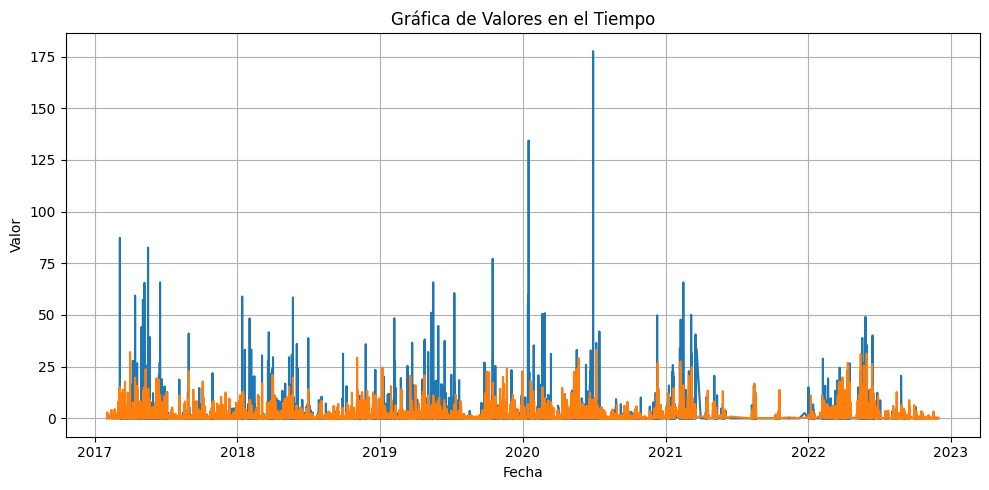

In [8]:
import matplotlib.pyplot as plt


# Crear la gráfica
plt.figure(figsize=(10, 5))
plt.plot(dataset, marker='', linestyle='-')

# Añadir títulos y etiquetas
plt.title('Gráfica de Valores en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()


In [9]:
import plotly.express as px

# Asegurar que el índice sea datetime
dataset.index = pd.to_datetime(dataset.index)

# Crear la gráfica en Plotly
fig = px.line(dataset, title='Gráfica de Valores en el Tiempo')

# Personalizar el gráfico con etiquetas y títulos
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Valor',
    template='plotly_dark'  # O puedes usar 'plotly' para un estilo claro
)

# Mostrar la gráfica
fig.show()
correlation = dataset[red_mpomm_metadata['station']].corr(dataset[msweb_metadata['name']])
correlation


np.float64(0.3545913433173262)

In [14]:
dataset_resample= dataset.resample('D').sum()
# Crear la gráfica en Plotly
fig = px.line(dataset_resample, title=f'Gráfica de Valores en el Tiempo {dataset['Tumaco'].corr(dataset['point_2'])}')

# Personalizar el gráfico con etiquetas y títulos
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Valor',
    template='plotly_dark'  # O puedes usar 'plotly' para un estilo claro
)

# Mostrar la gráfica
fig.show()
correlation = dataset_resample[red_mpomm_metadata['station']].corr(dataset_resample[msweb_metadata['name']])
correlation

np.float64(0.4557387007702392)

In [11]:
chirps_series_df = chirps_series.to_frame('chirps')

# Ahora puedes usar join
dataset_2 = dataset.join(chirps_series_df, how='inner')
dataset_2

,Tumaco,point_2,timestamp
2017-02-02,0.0,2.937500,2017-02-02
2017-02-07,0.0,0.375000,2017-02-07
2017-02-19,0.0,0.000000,2017-02-19
2017-02-24,0.0,0.000000,2017-02-24
2017-02-26,0.0,0.000000,2017-02-26
...,...,...,...
2022-11-20,0.0,0.345924,2022-11-20
2022-11-21,0.0,0.015513,2022-11-21
2022-11-22,0.0,0.005019,2022-11-22
2022-11-23,0.0,0.001118,2022-11-23
